In [1]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# 可选：在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"


In [2]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)


In [54]:
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START


# 创建智能体的函数，绑定 LLM（大型语言模型） 和工具
def create_agent(llm, tools, system_message: str):
    """创建一个智能体。"""
    # 定义智能体的提示模板，包含系统消息和工具信息
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),  # 用于替换的消息占位符
        ]
    )
    
    # 将系统消息部分和工具名称插入到提示模板中
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    
    # 将提示模板与语言模型和工具绑定
    return prompt | llm.bind_tools(tools)



### 2. 定义工具

接下来我们定义一些未来智能体将使用的工具。

#### 注释说明：
- `tavily_tool`: 定义了一个 Tavily 搜索工具，可以搜索最多 5 条结果。
- `repl`: 定义了一个 Python REPL 工具，用于执行 Python 代码块。
- `python_repl` 函数：这是一个装饰的工具函数，接受 Python 代码作为输入，并通过 `PythonREPL` 环境执行代码。成功执行后返回执行的代码和输出。如果发生错误，则捕获并返回错误信息。


In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Tavily 搜索工具，用于搜索最多 5 条结果
tavily_tool = TavilySearchResults(max_results=5)

# Python REPL 工具，用于执行 Python 代码
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

-----------

### 3. 辅助函数：智能体节点

下面我们定义智能体节点函数（`agent_node`)，然后使用它分别定义2个智能体节点：
- Researcher
- Chart Generator

#### 注释说明：

- `agent_node` 函数是一个辅助函数，用于创建一个智能体节点。它接受当前的 `state`（状态）、`agent`（智能体） 和 `name`（智能体的名称），并返回一个新的状态字典，包含消息和发送者。
- `research_agent`: 使用 `create_agent` 函数创建了一个研究智能体，使用 `research_llm` 作为语言模型，并且绑定了 `tavily_tool` 搜索工具。
- `chart_agent`: 同样使用 `create_agent` 创建了图表生成器智能体，使用 `chart_llm` 作为语言模型，并绑定了 `python_repl` 代码执行工具。
- `functools.partial`: 用于创建特定名称的智能体节点，例如 `"Researcher"` 和 `"Chart Generator"`，并与各自的智能体绑定。

In [4]:
import functools
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

# 辅助函数：为智能体创建一个节点
def agent_node(state, agent, name):
    # 调用智能体，获取结果
    result = agent.invoke(state)
    
    # 将智能体的输出转换为适合追加到全局状态的格式
    if isinstance(result, ToolMessage):
        print(f"ToolMessage: {result}")
        
        pass  # 如果是工具消息，跳过处理
    else:
        # 将结果转换为 AIMessage，并排除部分字段
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    
    # 返回更新后的状态，包括消息和发送者
    return {
        "messages": [result],  # 包含新生成的消息
        # 我们使用严格的工作流程，通过记录发送者来知道接下来传递给谁
        "sender": name,
    }

#### 关于 `AIMessage` 构造

`AIMessage` 是 LangChain 中用于表示 AI 模型回复的类，它封装了 AI 生成的文本或内容。为了让 Python 初学者更好地理解，我们可以从以下几个方面详细说明 `AIMessage` 的构造方法及其相关概念。

##### `AIMessage` 构造方法简介

在代码中，`AIMessage(**result.dict(exclude={"type", "name"}), name=name)` 这段代码使用了 `AIMessage` 的构造方法。`AIMessage` 的目的是将 AI 生成的消息封装起来，方便后续处理和传递。这里的构造方法通过传递字典参数创建 `AIMessage` 对象。

##### `AIMessage` 类的常见构造参数：
- **content**: 这是消息的主要部分，通常是 AI 模型生成的文本内容。例如，一个简单的对话模型可能会生成一个包含回答问题的字符串。
- **name**: 可选参数，用于标识发送消息的 AI 模型或智能体的名称。在你的代码中，`name=name` 表示为智能体分配一个名称（如 `"Researcher"` 或 `"Chart Generator"`），以便在不同智能体之间进行区分。
- **additional_metadata**: 有时候，消息不仅仅包含文本内容，还可能附加其他元数据，如调用的工具、时间戳等。

##### 深入理解构造方法中的步骤：

1. **`result.dict()`**: 
   这一部分将 `result` 对象转换为字典。字典是一种键值对的结构，便于存储和管理数据。Python 中的 `dict()` 方法会把 `result` 对象的所有属性转换成字典的形式，方便在构造 `AIMessage` 时传递这些数据。

2. **`exclude={"type", "name"}`**:
   在构造 `AIMessage` 时，使用了 `exclude` 参数来排除某些不必要的字段。`type` 和 `name` 这两个字段不会被传递给 `AIMessage`，这是因为它们可能不是 AI 消息本身的必要部分或已经在其他地方定义过。

3. **`name=name`**:
   这里的 `name` 参数表示智能体的名称，它是在 `agent_node` 函数中作为参数传递的。在构造 `AIMessage` 时，通过这个参数来标识消息的来源智能体是谁，比如 `"Researcher"` 或 `"Chart Generator"`。

--------------

### 4. 定义 研究智能体及其节点


In [5]:
# 为 Agent 配置各自的大模型
research_llm = ChatOpenAI(model="gpt-4o", temperature=0.5)
chart_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [32]:
# 研究智能体及其节点
research_agent = create_agent(
    research_llm,  # 使用 research_llm 作为研究智能体的语言模型
    [tavily_tool],  # 研究智能体使用 Tavily 搜索工具
    system_message="using the search engine, just search and return the result,do not create table",  # 系统消息，指导智能体如何使用搜索工具
)

In [33]:
# 使用 functools.partial 创建研究智能体的节点，指定该节点的名称为 "Researcher"
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

### 5. 定义 表格生成器智能体及其节点

In [34]:
chart_agent = create_agent(
    chart_llm,  # 使用 chart_llm 作为图表生成器智能体的语言模型
    [],  # 图表生成器智能体使用 Python REPL 工具
    system_message="Create table based on the provided data.",  # 系统消息，指导智能体如何生成图表
)

In [35]:
# 使用 functools.partial 创建图表生成器智能体的节点，指定该节点的名称为 "Chart Generator"
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

In [36]:
from langgraph.prebuilt import ToolNode

# 定义工具列表，包括 Tavily 搜索工具和 Python REPL 工具
tools = [tavily_tool, python_repl]

# 创建工具节点，负责工具的调用
tool_node = ToolNode(tools)

------------------------


### 7. 建立智能体节点间通信 AgentState

定义智能体节点和工具节点后，接下来需要在 Graph 中使它们互相通信。

因此，我们需要定义节点间的消息传递数据结构：AgentState

我们使用一个消息列表，并包含一个键来跟踪最近的发送者。

#### 注释说明：
- `AgentState` 是一个 `TypedDict`，它定义了图中传递的状态对象，包括 `messages` 和 `sender`。`messages` 用于存储传递的消息，`sender` 用于跟踪消息的发送者。


In [37]:
import operator
from typing import Annotated, Sequence, TypedDict

# 定义图中传递的对象，包含消息和发送者信息
class AgentState(TypedDict):
    # messages 是传递的消息，使用 Annotated 和 Sequence 来标记类型
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # sender 是发送消息的智能体
    sender: str


### 8. 定义工作流（状态图）

我们现在将所有内容组合在一起，定义多智能体的完整状态图。

#### 注释说明：

- `StateGraph(AgentState)`：用于创建一个状态图 `workflow`，其状态由 `AgentState` 管理。
- `add_node`：将智能体节点 `Researcher`、`Chart Generator` 和 `call_tool` 添加到状态图中，每个节点对应一个任务或功能。
- `add_conditional_edges`：为节点添加条件边，基于 `router` 函数的返回值来决定下一个要执行的步骤。
  - `continue`：继续到另一个智能体节点。
  - `call_tool`：调用工具节点。
  - `__end__`：结束流程。
- `add_edge`：将开始节点 `START` 与初始节点 `Researcher` 连接，定义工作流的启动顺序。
- `compile`：编译状态图，准备好执行任务。

#### Graph 对象关键方法 API

- **add_conditional_edges**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#stategraph
- **get_graph**: https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+conditional+edges#langgraph.graph.graph.CompiledGraph.get_graph


In [38]:
# 创建一个状态图 workflow，使用 AgentState 来管理状态
workflow = StateGraph(AgentState)

# 将研究智能体节点、图表生成器智能体节点和工具节点添加到状态图中
workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)


#### 定义路由函数

接下来定义边逻辑，以根据智能体的结果来决定下一步操作。

#### 注释说明：
- `router` 函数是工作流中的一个关键逻辑，用于根据当前的状态和消息内容来决定下一步的操作。
- 如果最新的消息中包含工具调用（`tool_calls`），则返回 `"call_tool"`，表示需要调用工具。
- 如果消息内容中包含 `"FINAL ANSWER"`，表示任务已经完成，返回 `"__end__"` 来结束任务。
- 如果没有满足以上条件，则返回 `"continue"`，表示继续任务并执行下一步操作。

In [39]:
from typing import Literal

# 路由器函数，用于决定下一步是执行工具还是结束任务
def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]  # 获取当前状态中的消息列表
    last_message = messages[-1]  # 获取最新的一条消息
    
    # 如果最新消息包含工具调用，则返回 "call_tool"，指示执行工具
    if last_message.tool_calls:
        return "call_tool"
    
    # 如果最新消息中包含 "FINAL ANSWER"，表示任务已完成，返回 "__end__" 结束工作流
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    
    # 如果既没有工具调用也没有完成任务，继续流程，返回 "continue"
    return "continue"


#### 定义条件边逻辑

In [40]:
# 为 "Researcher" 智能体节点添加条件边，根据 router 函数的返回值进行分支
workflow.add_conditional_edges(
    "Researcher",
    router,  # 路由器函数决定下一步
    {
        "continue": "Chart Generator",  # 如果 router 返回 "continue"，则传递到 Chart Generator
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "Chart Generator" 智能体节点添加条件边
workflow.add_conditional_edges(
    "Chart Generator",
    router,  # 同样使用 router 函数决定下一步
    {
        "continue": "Researcher",  # 如果 router 返回 "continue"，则回到 Researcher
        "call_tool": "call_tool",  # 如果 router 返回 "call_tool"，则调用工具
        "__end__": END  # 如果 router 返回 "__end__"，则结束工作流
    },
)

# 为 "call_tool" 工具节点添加条件边，基于“sender”字段决定下一个节点
# 工具调用节点不更新 sender 字段，这意味着边将返回给调用工具的智能体
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],  # 根据 sender 字段判断调用工具的是哪个智能体
    {
        "Researcher": "Researcher",  # 如果 sender 是 Researcher，则返回给 Researcher
        "Chart Generator": "Chart Generator",  # 如果 sender 是 Chart Generator，则返回给 Chart Generator
    },
)


In [41]:
# 添加开始节点，将流程从 START 节点连接到 Researcher 节点
workflow.add_edge(START, "Researcher")

# 编译状态图以便后续使用
graph = workflow.compile()

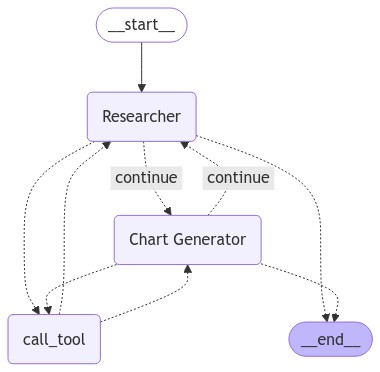

In [42]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")


### 9. 执行工作流

接下来我们将执行多智能体构建的工作流，最终生成一些统计图表。

In [43]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="first Obtain the GDP of the United States from 2000 to 2020, "
            "second make a table based on the data. End the task after generating the table."
            )
        ],
    },
    # 设置最大递归限制
    {"recursion_limit": 20},
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()  # 打印消息内容


================================ Human Message =================================

first Obtain the GDP of the United States from 2000 to 2020, second make a table based on the data. End the task after generating the table.
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search_results_json (call_t28nvgJwNhtJI4nkc8XmZ3Jy)
 Call ID: call_t28nvgJwNhtJI4nkc8XmZ3Jy
  Args:
    query: United States GDP 2000 to 2020 data
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.bea.gov/news/2021/gross-domestic-product-4th-quarter-and-year-2020-advance-estimate", "content": "Real gross domestic product (GDP) increased at an annual rate of 4.0 percent in the fourth quarter of 2020 (table 1), according to the \"advance\" estimate released by the Bureau of Economic Analysis. In the third quarter, real GDP increased 33.4 percent. The GDP estimate rel

## Homework

1. 使用不同的大模型运行多智能体，对比结果并评选 `gpt-4o` 之下最好的大模型，将所有的大模型和最终结果生成一张表格；
2. 将 `Chart Generator` 替换为其他功能智能体（如 `table_generator`），为其设计提示词，然后运行查看生成结果。
3. [**可选**]优化研究智能体 `Researcher` 提示词和路由函数 `route` 跳转逻辑，提升图表生成的成功率。